In [87]:
import pandas as pd
import re
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from collections import Counter

from simpletransformers.classification import ClassificationModel

In [268]:
import streamlit

In [274]:
streamlit.version

<module 'streamlit.version' from '/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/version.py'>

In [5]:
%ls

Extending_dataset.ipynb
Genre_prediction.ipynb
Genres.csv
IMDB Dataset.csv
Prepared_imdb_data.pkl
Preparing to genre prediction.ipynb
Researching_dataset.ipynb
Sent_bert.ipynb
Sentimental analisys.ipynb
aclImdb/
aclImdb_v1.tar.gz.tar.gz
archive/
archive.zip
backup/
before_data_cleaning/
before_data_cleaning-20230114T182908Z-001.zip
cache_dir/
extended_dataset.csv
extended_dataset.csv.zip
for_genre_prediction.csv
full_to_genre_prediction.csv
kinopoisk-top250.csv
outputs/
prepared_imdb.csv
runs/
trmodel
wiki_movie_plots_deduped.csv
with_predicted_genres.csv
with_sentiment.csv
Марат Гарафутдинов. Школа DS. Итоговый проект (1).docx
Кинопоиск.ipynb
Кинопоиск_250.ipynb


In [6]:
df = pd.read_csv('extended_dataset.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39686 entries, 0 to 39685
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        39686 non-null  int64  
 1   Release Year      39685 non-null  float64
 2   Title             39686 non-null  object 
 3   Origin/Ethnicity  39686 non-null  object 
 4   Director          39656 non-null  object 
 5   Cast              38222 non-null  object 
 6   Genre             39658 non-null  object 
 7   Url               36598 non-null  object 
 8   Plot              39686 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.7+ MB


In [8]:
df.head(5)

,Unnamed: 0,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Url,Plot
0,0,1901.0,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1,1901.0,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,2,1901.0,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,3,1901.0,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,4,1902.0,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


In [9]:
df.info() # посмотрим на общую картинку

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39686 entries, 0 to 39685
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        39686 non-null  int64  
 1   Release Year      39685 non-null  float64
 2   Title             39686 non-null  object 
 3   Origin/Ethnicity  39686 non-null  object 
 4   Director          39656 non-null  object 
 5   Cast              38222 non-null  object 
 6   Genre             39658 non-null  object 
 7   Url               36598 non-null  object 
 8   Plot              39686 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 2.7+ MB


In [10]:
df[df['Genre'] == 'unknown'].count()

Unnamed: 0          6083
Release Year        6083
Title               6083
Origin/Ethnicity    6083
Director            6083
Cast                5400
Genre               6083
Url                 6083
Plot                6083
dtype: int64

In [11]:
df.replace('unknown', np.nan, inplace=True) #Немного причешем датасет
df.replace('Unknown', np.nan, inplace=True)

df.dropna(subset=['Plot',], inplace=True) # выкинем все, что без описания и обновим индексы
df.reset_index(drop=True, inplace=True)

df.drop('Unnamed: 0', axis=1, inplace=True) # дропнем лишнюю колонку



In [12]:
df.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Url,Plot
0,1901.0,Kansas Saloon Smashers,American,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901.0,Love by the Light of the Moon,American,NaN,NaN,NaN,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901.0,The Martyred Presidents,American,NaN,NaN,NaN,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901.0,"Terrible Teddy, the Grizzly King",American,NaN,NaN,NaN,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902.0,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,NaN,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


### Приведем жанры в порядок

In [13]:
def replacing_film(x):
    if type(x) == str:
        return x.replace('film', '').lower().strip() # уберем слово "фильм", а также приведем всё к одному регистру.

In [14]:
df['Genre'] = df['Genre'].apply(replacing_film)

In [15]:
df['Genre'].nunique() # итого 2188 жанров на старте

2188

In [16]:
most_freq_genres = df["Genre"].value_counts()
most_freq_genres[:50]

drama               7202
comedy              5445
action              1874
horror              1473
thriller            1178
romance             1046
western              892
adventure            867
crime                763
science fiction      516
musical              467
romantic comedy      465
crime drama          464
animation            388
mystery              351
noir                 345
fantasy              321
war                  302
family               287
comedy, drama        240
sci-fi               221
animated             220
documentary          161
musical comedy       154
comedy-drama         137
biography            136
anime                112
suspense             104
comedy drama         104
romantic drama       103
drama, romance        94
animated short        91
social                83
historical            79
action thriller       79
serial                71
world war ii          70
family drama          66
war drama             65
drama, crime          64


In [17]:
# Собрал все в кучу для использования в другом файле

# df['Genre'] = df['Genre'].apply(lambda x: x.replace('sci-fi', 'science fiction').replace('science-fiction', 'science fiction') if x != None else None)

# comedy_pattern = r'.*comedy.*'
# drama_pattern = r'.*drama.*'
# war_pattern = r'.*war.*'
# thriller_pattern = r'.*thriller.*'

# df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(comedy_pattern, x).group(), 'comedy') 
#                                 if len(re.findall(comedy_pattern, str(x))) != 0 else x)
# df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(drama_pattern, x).group(), 'drama') 
#                                 if len(re.findall(drama_pattern, str(x))) != 0 else x)
# df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(war_pattern, x).group(), 'war') 
#                                 if len(re.findall(war_pattern, str(x))) != 0 else x)
# df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(thriller_pattern, x).group(), 'thriller') 
#                                 if len(re.findall(thriller_pattern, str(x))) != 0 else x)


# most_freq_genres = df["Genre"].value_counts()
# top25_genres = tuple(most_freq_genres[:25].index)
# def regenrator(x): 
#     '''Выцепим все самые популярные жанры из оставшихся записей'''
#     if x is None:
#         return np.nan
#     if x in top25_genres:
#         return x
#     else:
#         for i in top25_genres:
#             if str(i) in str(x):
#                 return i
#     return x


# df["Genre"] = df['Genre'].apply(regenrator)

# most_freq_genres = df["Genre"].value_counts()
# top30_genres = tuple(most_freq_genres[:30].index)


# df.dropna(subset=['Genre'], inplace=True) # выкинем все, что без описания и обновим индексы
# df.reset_index(drop=True, inplace=True)


In [18]:
df['Genre'] = df['Genre'].apply(lambda x: x.replace('sci-fi', 'science fiction').replace('science-fiction', 'science fiction') if x != None else None)

In [19]:
comedy_pattern = r'.*comedy.*'
drama_pattern = r'.*drama.*'
war_pattern = r'.*war.*'
thriller_pattern = r'.*thriller.*'

In [20]:
df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(comedy_pattern, x).group(), 'comedy') 
                                if len(re.findall(comedy_pattern, str(x))) != 0 else x)
df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(drama_pattern, x).group(), 'drama') 
                                if len(re.findall(drama_pattern, str(x))) != 0 else x)
df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(war_pattern, x).group(), 'war') 
                                if len(re.findall(war_pattern, str(x))) != 0 else x)
df['Genre'] = df['Genre'].apply(lambda x: x.replace(re.search(thriller_pattern, x).group(), 'thriller') 
                                if len(re.findall(thriller_pattern, str(x))) != 0 else x)

In [21]:
most_freq_genres = df["Genre"].value_counts()
top25_genres = tuple(most_freq_genres[:25].index)
def regenrator(x): 
    '''Выцепим все самые популярные жанры из оставшихся записей'''
    if x is None:
        return np.nan
    if x in top25_genres:
        return x
    else:
        for i in top25_genres:
            if str(i) in str(x):
                return i
    return x

In [22]:
df["Genre"] = df['Genre'].apply(regenrator)
df['Genre'] = df['Genre'].apply(lambda x: str(x).replace('animated', 'animation').replace('anime', 'animation') if x != None else None)
df['Genre'] = df['Genre'].replace('nan', np.nan)

In [23]:
most_freq_genres = df["Genre"].value_counts()
top20_genres = tuple(most_freq_genres[:20].index)

In [24]:
top20_genres # их оставим, а остальное будет np.nan

('drama',
 'comedy',
 'action',
 'thriller',
 'horror',
 'romance',
 'adventure',
 'western',
 'animation',
 'crime',
 'science fiction',
 'musical',
 'war',
 'fantasy',
 'mystery',
 'noir',
 'family',
 'documentary',
 'biography',
 'suspense')

In [25]:
def top_20_genres(x):
    'Оставим только 20 самых популярных жанров, остальное - nan'
    if x in top20_genres:
        return x
    else:
        return np.nan

In [26]:
df["Genre"] = df['Genre'].apply(top_20_genres)

In [27]:
most_freq_genres = df["Genre"].value_counts()
most_freq_genres

drama              9882
comedy             8308
action             2380
thriller           1765
horror             1590
romance            1150
adventure           954
western             922
animation           796
crime               792
science fiction     790
musical             519
war                 450
fantasy             382
mystery             358
noir                350
family              320
documentary         174
biography           144
suspense            104
Name: Genre, dtype: int64

In [28]:
df.dropna(subset=['Genre'], inplace=True) # выкинем все, что без описания и обновим индексы
df.reset_index(drop=True, inplace=True)


In [29]:
df

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Url,Plot
0,1903.0,The Great Train Robbery,American,Edwin S. Porter,NaN,western,https://en.wikipedia.org/wiki/The_Great_Train_...,The film opens with two bandits breaking into ...
1,1904.0,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
2,1906.0,From Leadville to Aspen: A Hold-Up in the Rockies,American,Francis J. Marion and Wallace McCutcheon,NaN,action,https://en.wikipedia.org/wiki/From_Leadville_t...,The film features a train traveling through th...
3,1907.0,How Brown Saw the Baseball Game,American,NaN,NaN,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
4,1907.0,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
...,...,...,...,...,...,...,...,...
32125,2004.0,Primer,English,Shane Carruth,"Shane Carruth, David Sullivan, Casey Gooden, A...",science fiction,http://www.primermovie.com,Friends/fledgling entrepreneurs invent a devic...
32126,1992.0,El Mariachi,Spanish; Castilian,Robert Rodriguez,"Carlos Gallardo, Jaime de Hoyos, Peter Marquar...",action,NaN,El Mariachi just wants to play his guitar and ...
32127,2011.0,Newlyweds,English,Edward Burns,"Edward Burns, Kerry Bishé, Marsha Dietlein, Ca...",comedy,NaN,A newlywed couple's honeymoon is upended by th...
32128,2013.0,"Signed, Sealed, Delivered",English,Scott Smith,"Eric Mabius, Kristin Booth, Crystal Lowe, Geof...",comedy,http://www.hallmarkchannel.com/signedsealeddel...,"""Signed, Sealed, Delivered"" introduces a dedic..."


In [30]:
cutted_df = df.groupby("Genre").head(400).reset_index(drop=True) 
# обрежем до максимум 400(чуть выше медианы) фильмов в жанре, чтобы не было слишком явного дисбаланса при обучении

In [31]:
cutted_df.Genre.value_counts()

western            400
comedy             400
science fiction    400
musical            400
thriller           400
war                400
animation          400
romance            400
crime              400
horror             400
adventure          400
drama              400
action             400
fantasy            382
mystery            358
noir               350
family             320
documentary        174
biography          144
suspense           104
Name: Genre, dtype: int64

In [32]:
label_encoder = LabelEncoder()
cutted_df["genre_encoded"] = label_encoder.fit_transform(cutted_df["Genre"].tolist())

In [33]:
df_to_model = cutted_df[["Plot", "Genre", "genre_encoded"]]
df_to_model

,Plot,Genre,genre_encoded
0,The film opens with two bandits breaking into ...,western,19
1,The film is about a family who move to the sub...,comedy,4
2,The film features a train traveling through th...,action,0
3,Before heading out to a baseball game at a nea...,comedy,4
4,The plot is that of a black woman going to the...,comedy,4
...,...,...,...
7027,An associative collection of visual impression...,documentary,6
7028,"The Cyclone, The Freakshow, The Mermaid Parade...",documentary,6
7029,"Twenty years ago, seven superstar artists left...",documentary,6
7030,Martin Scorsese's rockumentary intertwines foo...,documentary,6


In [34]:
df_to_model.to_csv('for_genre_prediction.csv')

In [ ]:
Далее уже работа с колабом

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab/for_genre_prediction.csv')
num_labels = len(set(data.genre_encoded))
model_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "max_seq_length": 512,
    "train_batch_size": 16,
    "num_train_epochs": 4,
}

# Create a ClassificationModel
model = ClassificationModel('bert', 'bert-base-cased', num_labels=num_labels, args=model_args,
                            use_cuda=True)

In [ ]:
train_df, eval_df = train_test_split(data, test_size=0.2, stratify= data["Genre"], random_state=42)

In [ ]:
model.train_model(train_df[["Plot", "genre_encoded"]])

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(eval_df[["Plot", "genre_encoded"]])
print(result)

In [44]:
{'mcc': 0.5817846652188374, 'eval_loss': 1.3338974741372196}
# {'mcc': 0.49048115546234367, 'eval_loss': 1.636696330566502}  # обучена до очистки данных. и до сокращения кол-ва жанров
# {'mcc': 0.46240450620118595, 'eval_loss': 1.7098242934025711} обучена после применения clear_data on plot

{'mcc': 0.5817846652188374, 'eval_loss': 1.3338974741372196}

In [49]:
first_genre_encoded = list(map(lambda x: np.argmax(x), model_outputs))
eval_df['first_genre_predicted'] = first_genre_encoded

sec_genre = model_outputs.copy()
for i, pred in enumerate(first_genre_encoded):
      sec_genre[i][pred] = 0

second_genre_encoded = list(map(lambda x: np.argmax(x), sec_genre))
eval_df['second_genre_encoded'] = second_genre_encoded


In [ ]:
# На всякий случай, загрузим модель, которую обучили.

In [50]:
model = ClassificationModel('bert', './genre_classif_model/outputs/', use_cuda = False)

In [216]:
# eval_df.Plot[0:2].to_list()

In [66]:
predictions, raw_outputs = model.predict(eval_df.Plot[0:2].to_list())

  0%|          | 0/2 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

In [68]:
predictions

[19, 11]

In [53]:
eval_df = pd.read_csv('eval_df_genres.csv')

In [70]:
eval_df.drop(['Unnamed: 0.1', 'Unnamed: 0'], axis=1, inplace=True)

In [71]:
eval_df

,Plot,Genre,genre_encoded,first_genre_predicted,second_genre_encoded
0,After her Chicago gambling hall burns down in ...,western,19,19,1
1,Mary McGuire (Mae Murray) is a working-class y...,comedy,4,11,4
2,"When Sophie, a shy young woman, is cursed with...",fantasy,9,9,10
3,In the seven-and-a-half-minute pre-credits seq...,horror,10,10,9
4,"Woodrow ""Woody"" Wilkins is an imaginative, yet...",adventure,1,0,9
...,...,...,...,...,...
1402,"Returning to New York City from Europe, Boston...",mystery,12,12,5
1403,"In the 1840s, Captain Michael Fury (Brian Aher...",action,0,19,1
1404,Khaled falls in love with his friend Suhair. H...,romance,14,14,8
1405,While the Genie and the people of Agrabah prep...,animation,2,2,8


In [72]:
predicted_genres = list(label_encoder.inverse_transform(eval_df['first_genre_predicted']))


### Раскодируем обратно жанры

In [74]:
eval_df['first_genre_predicted_decoded'] = list(label_encoder.inverse_transform(eval_df['first_genre_predicted']))

In [75]:
eval_df['second_genre_decoded'] = list(label_encoder.inverse_transform(eval_df['second_genre_encoded']))

In [80]:
(eval_df['genre_encoded'] != eval_df.first_genre_predicted).sum()
# Итого 557 жанров, которые мы предсказали неверно.

557

### Построим confusion_matrix

In [214]:
# label_encoder.classes_

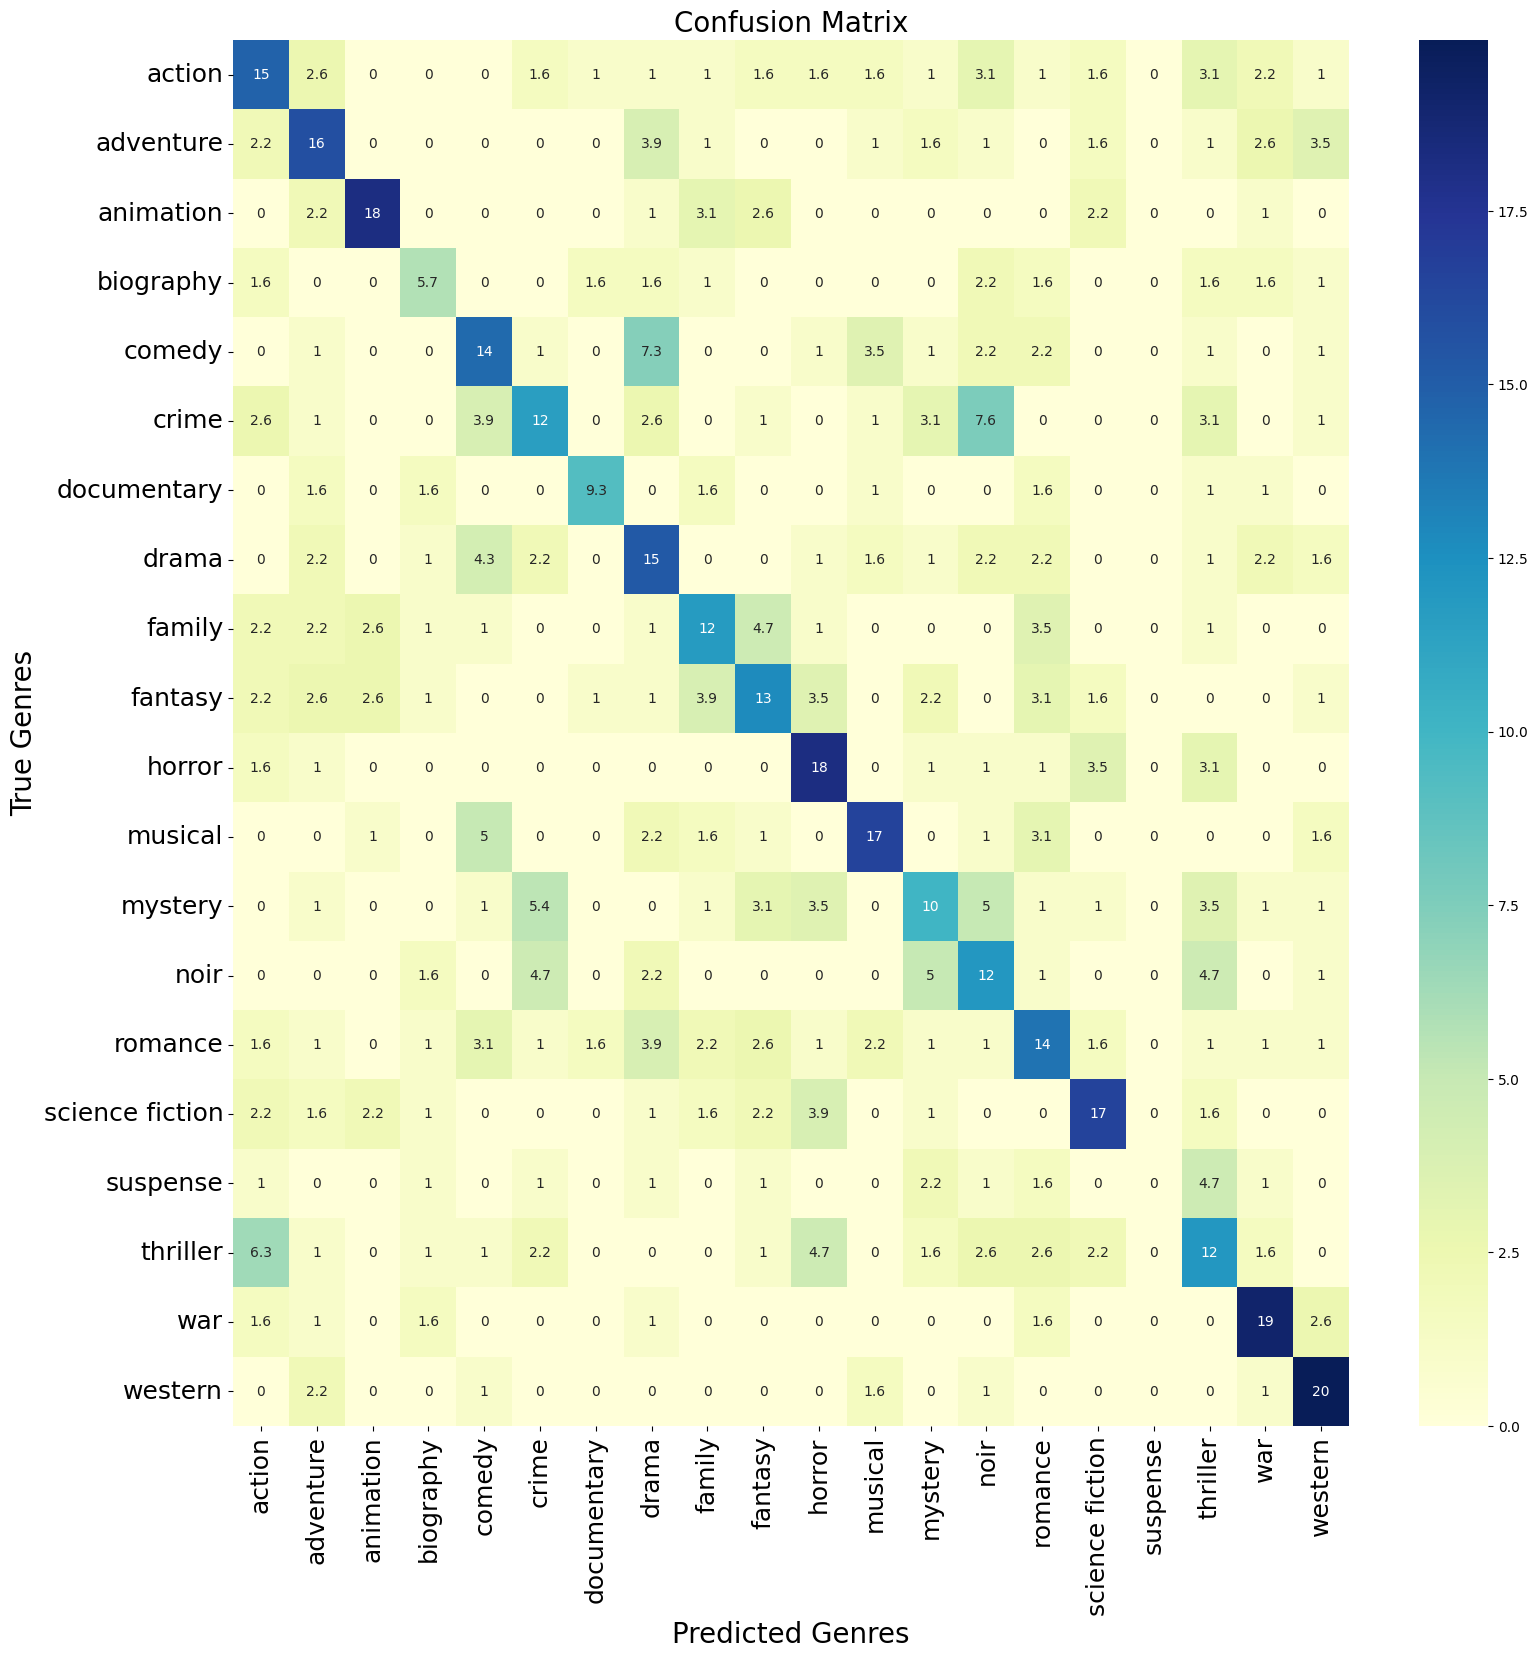

In [118]:
eval_gt_labels = eval_df["Genre"].tolist()
class_labels = list(label_encoder.classes_)

plt.figure(figsize=(18,18))
cf_matrix = confusion_matrix(eval_gt_labels, predicted_genres, labels=class_labels)
ax = sns.heatmap(cf_matrix**0.7, annot=True, cmap="YlGnBu") #YlGnBu Добавил нелинейности, чтобы немного сгладить пики.
ax.set_xlabel('Predicted Genres', fontsize=20)
ax.set_ylabel('True Genres', fontsize=20)
ax.set_title('Confusion Matrix', fontsize=20)
ax.set_xticklabels(class_labels, rotation=90, fontsize=18)
ax.set_yticklabels(class_labels, rotation=0, fontsize=18)

plt.show()

##### Из выводов можно сказать, что в целом предсказывает правильно, есть явные пересечения по жанрам. 
##### Посмотрим по тем жанрам, где было предсказано неправильно, какие еще жанры предлагались.

In [122]:
genre_mapping = eval_df[eval_df['genre_encoded'] != eval_df.first_genre_predicted][['Genre', 'first_genre_predicted_decoded', 'second_genre_decoded']]

In [167]:
genre_mapping.reset_index(drop=True, inplace=True)

In [168]:
genre_mapping #Получили датафрейм с ошибками

,Genre,first_genre_predicted_decoded,second_genre_decoded
0,comedy,musical,comedy
1,adventure,action,fantasy
2,science fiction,horror,science fiction
3,thriller,horror,thriller
4,action,war,action
...,...,...,...
552,romance,comedy,drama
553,mystery,horror,mystery
554,documentary,war,biography
555,action,western,adventure


In [207]:
genre_list = list(genre_mapping.Genre.unique())
for genre in genre_list:
    g_map[genre] = list()

In [208]:
# g_map

In [209]:
for i, genre in enumerate(genre_mapping['Genre']):
#     print(genre)
    g_map[genre].append(genre_mapping.first_genre_predicted_decoded[i])
    g_map[genre].append(genre_mapping.second_genre_decoded[i])

In [188]:
# genre_mapping.first_genre_predicted_decoded[1]

In [210]:
# genre_list = list(genre_mapping.Genre.unique())
for genre in genre_list:
    g_map[genre] = Counter(g_map[genre]).most_common()[:3]

In [213]:
pd.DataFrame(g_map).transpose() # А это уже датафрейм с тем, что предсказала модель в 1-2 жанре по неверным предложениям. 
# В большинстве случаев на втором жанре был предложен верный класс, из датафрейма ниже это видно.

,0,1,2
comedy,"(drama, 23)","(comedy, 20)","(musical, 6)"
adventure,"(adventure, 11)","(drama, 8)","(action, 6)"
science fiction,"(horror, 8)","(science fiction, 8)","(animation, 5)"
thriller,"(thriller, 20)","(action, 20)","(horror, 11)"
action,"(action, 13)","(thriller, 9)","(noir, 8)"
war,"(war, 5)","(action, 5)","(western, 4)"
fantasy,"(family, 12)","(fantasy, 12)","(animation, 8)"
animation,"(fantasy, 8)","(family, 7)","(adventure, 5)"
musical,"(comedy, 12)","(drama, 11)","(musical, 8)"
romance,"(romance, 13)","(drama, 10)","(comedy, 9)"


### Теперь соберем модель, которая сможет предсказывать жанр по нашему тексту.

In [247]:
decode_dict = dict(zip(list(range(20)), list(label_encoder.classes_)))
decode_dict = {0: 'action',
 1: 'adventure',
 2: 'animation',
 3: 'biography',
 4: 'comedy',
 5: 'crime',
 6: 'documentary',
 7: 'drama',
 8: 'family',
 9: 'fantasy',
 10: 'horror',
 11: 'musical',
 12: 'mystery',
 13: 'noir',
 14: 'romance',
 15: 'science fiction',
 16: 'suspense',
 17: 'thriller',
 18: 'war',
 19: 'western'}

# повторил хардкодом, чтобы не потерялся

In [252]:
class genre_predictor:
    def __init__(self):
        self.model = ClassificationModel('bert', './genre_classif_model/outputs/', use_cuda = False)
        self.decode_dict =  {0: 'action',
                             1: 'adventure',
                             2: 'animation',
                             3: 'biography',
                             4: 'comedy',
                             5: 'crime',
                             6: 'documentary',
                             7: 'drama',
                             8: 'family',
                             9: 'fantasy',
                             10: 'horror',
                             11: 'musical',
                             12: 'mystery',
                             13: 'noir',
                             14: 'romance',
                             15: 'science fiction',
                             16: 'suspense',
                             17: 'thriller',
                             18: 'war',
                             19: 'western'}
        self.first_genre = None
        self.second_genre = None
        
    def predict(self, your_text):
        predictions, raw_outputs = self.model.predict([your_text])
        self.first_genre = decode_dict[predictions[0]]
        
        raw_outputs[0][predictions[0]] = 0
        self.second_genre = decode_dict[np.argmax(raw_outputs)]
        
        return self.first_genre, self.second_genre

In [255]:
predictor = genre_predictor()

In [256]:
predictor.predict(your_text)

  0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

('fantasy', 'comedy')

In [ ]:
model = ClassificationModel('bert', './genre_classif_model/outputs/', use_cuda = False)

In [217]:
your_text = 'Once upone a time'

In [218]:
predictions, raw_outputs = model.predict([your_text])

  0%|          | 0/1 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

In [239]:
first_genre = decode_dict[predictions[0]]

In [240]:
first_genre

'fantasy'

In [249]:
raw_outputs[0][predictions[0]] = 0
second_genre = decode_dict[np.argmax(raw_outputs)]

In [251]:
second_genre

'comedy'

In [ ]:
label_encoder.inverse_transform(eval_df['second_genre_encoded'])

In [275]:
os.system("simple-viewer")


2023-01-15 20:52:37.019 INFO    numexpr.utils: NumExpr defaulting to 8 threads.



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://192.168.1.3:8502



2023-01-15 20:52:45.056 Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 540, in get_or_create_cached_value
    return_value = _read_from_cache(
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 339, in _read_from_cache
    raise e
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 324, in _read_from_cache
    return _read_from_mem_cache(
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 242, in _read_from_mem_cache
    raise CacheKeyNotFoundError("Key not found in mem cache")
streamlit.legacy_caching.caching.CacheKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/envs/st/l

2023-01-15 20:54:01.919 Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 540, in get_or_create_cached_value
    return_value = _read_from_cache(
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 339, in _read_from_cache
    raise e
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 324, in _read_from_cache
    return _read_from_mem_cache(
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 242, in _read_from_mem_cache
    raise CacheKeyNotFoundError("Key not found in mem cache")
streamlit.legacy_caching.caching.CacheKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/envs/st/l

2023-01-15 20:59:41.422 Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/script_runner.py", line 354, in _run_script
    exec(code, module.__dict__)
  File "/Users/alex/Documents/Школа_DS_Сбер/Итоговый проект/run_simple_transformers_streamlit_app.py", line 5, in <module>
    streamlit_runner()
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/simpletransformers/streamlit/simple_view.py", line 220, in streamlit_runner
    if manual_model_load(model_class, model_type, model_name):
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/simpletransformers/streamlit/streamlit_utils.py", line 60, in wrapped_func
    raise st.ScriptRunner.StopException
AttributeError: module 'streamlit' has no attribute 'ScriptRunner'

2023-01-15 21:00:10.964 Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/script_runner.py", line 354, in _run_

2023-01-15 21:01:12.042 Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 540, in get_or_create_cached_value
    return_value = _read_from_cache(
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 339, in _read_from_cache
    raise e
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 324, in _read_from_cache
    return _read_from_mem_cache(
  File "/Users/alex/opt/anaconda3/envs/st/lib/python3.8/site-packages/streamlit/legacy_caching/caching.py", line 242, in _read_from_mem_cache
    raise CacheKeyNotFoundError("Key not found in mem cache")
streamlit.legacy_caching.caching.CacheKeyNotFoundError: Key not found in mem cache

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/alex/opt/anaconda3/envs/st/l

  Stopping...


0

In [267]:
# pip install streamlit

In [265]:
# pip install watchdog

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.1/88.1 kB 249.0 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [276]:
script = '''"""
# My first app
Here's our first attempt at using data to create a table:
"""

import streamlit as st
import pandas as pd
df = pd.DataFrame({
  'first column': [1, 2, 3, 4],
  'second column': [10, 20, 30, 40]
})

df'''

In [278]:
with open('test.py', 'w') as f:
    f.write(script)

In [ ]:
os.system("streamlit run test.py")


2023-01-15 21:15:53.657 INFO    numexpr.utils: NumExpr defaulting to 8 threads.



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://192.168.1.3:8502



In [ ]:
import streamlit as st
